### This notebook shows an example of using GAN to generate images

Source: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [2]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.datasets import fashion_mnist, mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import keras.optimizers 
from matplotlib import pyplot
import numpy as np
from math import sqrt

### Using the [fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset

In [3]:

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


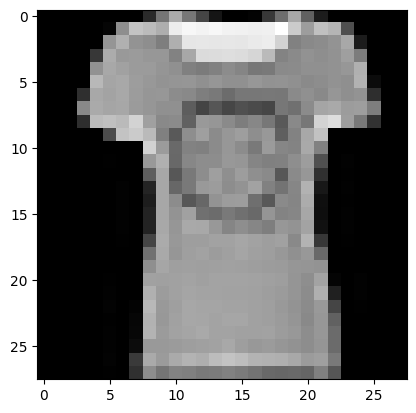

In [4]:
pyplot.imshow(X_train[441], cmap='gray')

In [5]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [6]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [7]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [8]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'mnist_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [9]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), int(1 + i))
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [10]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:
discriminator = define_discriminator()

c:\tools\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [13]:
generator = define_generator(100)

c:\tools\miniconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
gan_model = define_gan(generator, discriminator)

In [16]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)## This function saves the model for later use, as the training will take up some time
    return g_model

2/2 [==============================] - 0s 16ms/step
>1, dr[0.097,1.000], df[0.709,0.000], g[0.679,1.000]
2/2 [==============================] - 0s 6ms/step
>2, dr[0.040,1.000], df[0.722,0.000], g[0.668,1.000]
2/2 [==============================] - 0s 6ms/step
>3, dr[0.023,1.000], df[0.736,0.000], g[0.656,1.000]
2/2 [==============================] - 0s 3ms/step
>4, dr[0.018,1.000], df[0.760,0.000], g[0.641,1.000]
2/2 [==============================] - 0s 2ms/step
>5, dr[0.016,1.000], df[0.782,0.000], g[0.621,1.000]
2/2 [==============================] - 0s 3ms/step
>6, dr[0.013,1.000], df[0.812,0.000], g[0.604,1.000]
2/2 [==============================] - 0s 2ms/step
>7, dr[0.011,1.000], df[0.839,0.000], g[0.602,1.000]
2/2 [==============================] - 0s 2ms/step
>8, dr[0.012,1.000], df[0.846,0.000], g[0.602,1.000]
2/2 [==============================] - 0s 2ms/step
>9, dr[0.014,1.000], df[0.824,0.000], g[0.615,1.000]
2/2 [==============================] - 0s 3ms/step
>10, dr[0.01

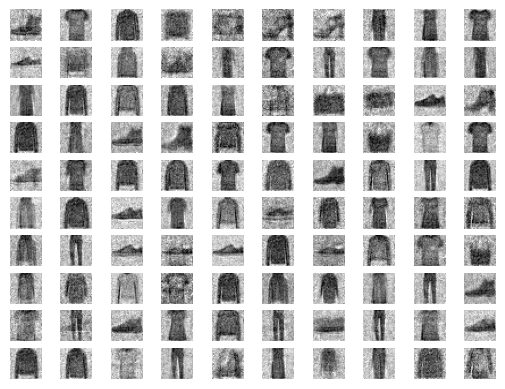

In [19]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

1/1 [==============================] - 0s 62ms/step


c:\tools\miniconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


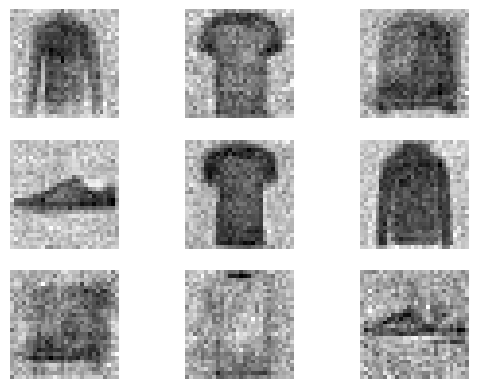

In [26]:
gan = load_model('/Models/Fashion/mnist_model_18740.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 9
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

## Lab 4
### Use this code to generate handwritten digits using the mnist dataset
#### The mnist dataset is available under keras.datasets

In [17]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


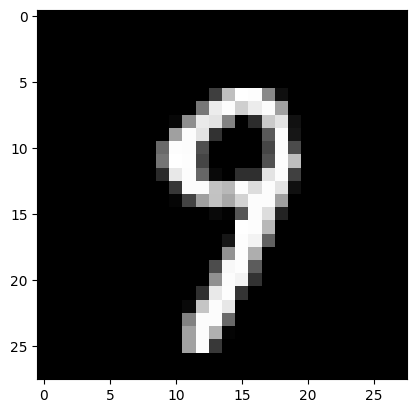

In [18]:
pyplot.imshow(X_train[441], cmap='gray')

In [19]:
discriminator = define_discriminator()
generator = define_generator(100)
gan_model = define_gan(generator, discriminator)

2/2 [==============================] - 0s 2ms/step
>1, dr[1.221,0.250], df[0.698,0.078], g[0.689,0.891]
2/2 [==============================] - 0s 2ms/step
>2, dr[0.053,1.000], df[0.709,0.000], g[0.680,1.000]
2/2 [==============================] - 0s 1ms/step
>3, dr[0.013,1.000], df[0.720,0.000], g[0.671,1.000]
2/2 [==============================] - 0s 2ms/step
>4, dr[0.009,1.000], df[0.733,0.000], g[0.660,1.000]
2/2 [==============================] - 0s 2ms/step
>5, dr[0.007,1.000], df[0.753,0.000], g[0.644,1.000]
2/2 [==============================] - 0s 2ms/step
>6, dr[0.004,1.000], df[0.777,0.000], g[0.626,1.000]
2/2 [==============================] - 0s 2ms/step
>7, dr[0.005,1.000], df[0.808,0.000], g[0.607,1.000]
2/2 [==============================] - 0s 2ms/step
>8, dr[0.006,1.000], df[0.838,0.000], g[0.598,1.000]
2/2 [==============================] - 0s 2ms/step
>9, dr[0.011,1.000], df[0.855,0.000], g[0.582,1.000]
2/2 [==============================] - 0s 2ms/step
>10, dr[0.012

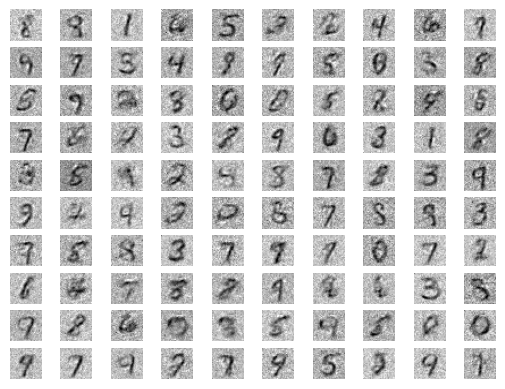

In [20]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

1/1 [==============================] - 0s 65ms/step


c:\tools\miniconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


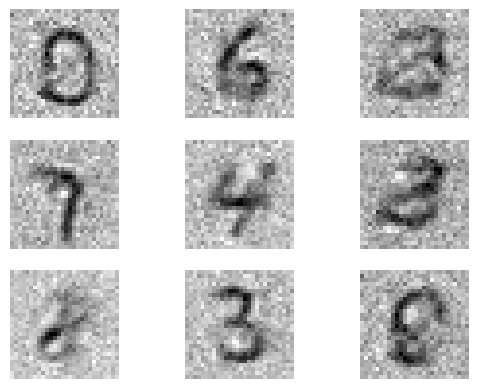

In [24]:
gan = load_model('Models/Digits/mnist_model_18740.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 9
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)